In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
matplotlib.style.use('ggplot')
import pickle as pkl
import itertools
import random
from collections import namedtuple
from keras.layers import Input, Dense, Flatten, Dropout, Conv1D, MaxPooling1D
from keras.models import Sequential, Model
from sklearn.preprocessing import StandardScaler
# from itertools import combinations_with_replacement
import math

2024-12-13 23:03:01.943520: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data exploration

<Axes: xlabel='Date', ylabel='cumm return'>

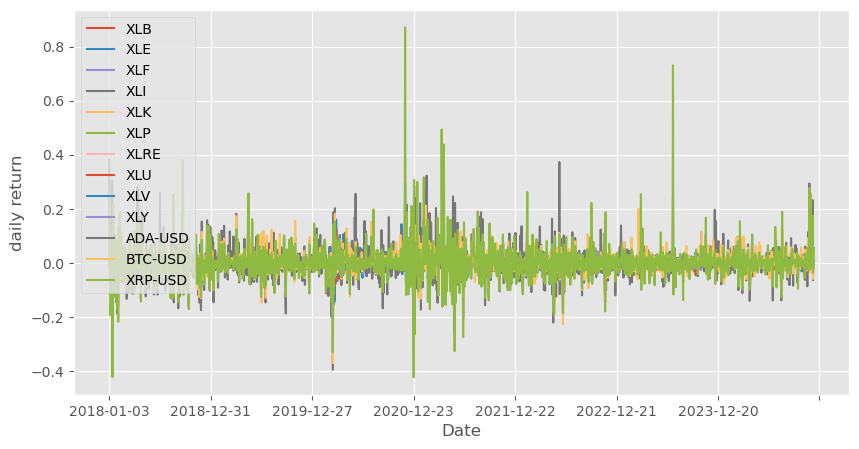

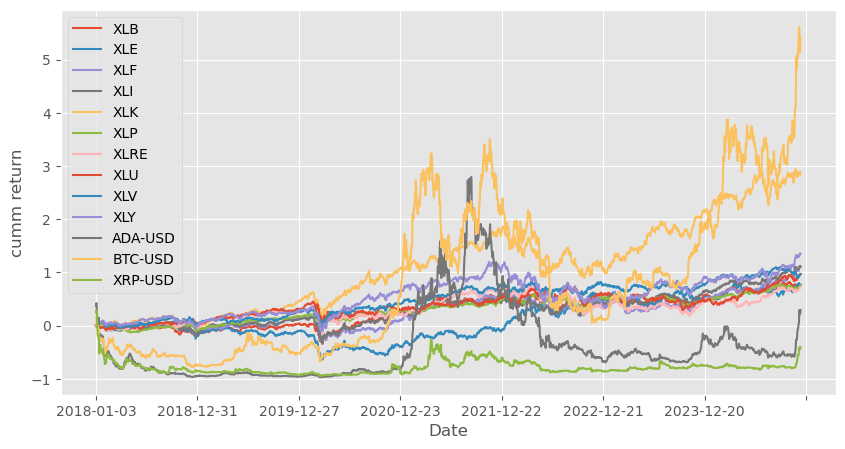

In [7]:
data = pd.read_csv("data/df_pct_change.csv", index_col=0)
data.plot(figsize = (10, 5), ylabel="daily return")

cum_return_ts = data.apply(lambda x: x+1).cumprod(axis=0)-1
cum_return_ts.plot(figsize = (10, 5), ylabel="cumm return")

In [31]:
# historical data split into 5
data = pd.read_csv("data/df_price.csv", index_col=0)
data_split = np.array_split(data, 5)
for i, data in enumerate(data_split):
    data.to_csv(f"data/df_price_{i}.csv")

/opt/anaconda3/envs/qf634/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [95]:
data = pd.read_csv("data/df_price.csv", index_col=0)
data.iloc[:1300].to_csv("data/df_price_train.csv")
data.iloc[1210:].to_csv("data/df_price_test.csv")

### Build RL Framework

In [4]:
class PortfolioEnv():
    def __init__(self
                 , input_file='data/df_price_4.csv'
                #  , capital = 1e6
                 , observe_window = 90
                 , rebalance_window = 30
                 , seed = None):  
        self.input_file = input_file     
        # self.capital = capital  
        self.prices = None # numpy array
        self.returns = None # numpy array
        self.asset_names = None # numpy array
        # self.seed = seed
        # self.rng = np.random.default_rng(self.seed)
        self.observe_window = observe_window
        self.rebalance_window = rebalance_window
        self.t = None # current time
        self.T = None
        self.n_asset = None
        self.done = False

        self._load_data() 
        self.reset()

    def _load_data(self):
        data = pd.read_csv(self.input_file)
        # data.index = data['Date']
        data = data.drop(columns = ['Date'])
        # data2 = data.pct_change().dropna()
        # self.prices = data.values
        # self.returns = data.values
        self.asset_names = data.columns
        self.T = data.shape[0]
        self.n_asset = data.shape[1]
        self.scaler = StandardScaler().fit(data.values)
        self.prices = self.scaler.transform(data.values)[1:]
        self.returns = data.pct_change().dropna().values
    
    def _reset(self, t=None):
        if t is not None:
            self.t = t
        else: 
            self.t = self.observe_window
        self.done = False
        state = self.check_state()
        return state
    
    def reset(self, t=None):
        return self._reset(t)
    
    def random_reset(self):
        self.t = random.randint(self.observe_window
                                , self.T - self.rebalance_window - 1)
        return self._reset(self.t)

    def check_state(self):
        assert self.observe_window <= self.t
        Pr_i_ts = self.prices[self.t - self.observe_window : min(self.t, self.T)]
        return Pr_i_ts
    
    def check_reward(self, action):
        try:
            W = self.normalize(action)
            R_i_ts = self.returns[self.t - self.rebalance_window : min(self.t, self.T)] # daily returns of the individual assets
            R_i = np.mean(R_i_ts, axis=0)  # mean returns of the individual assets
            # V = np.cov(R_i_ts.T)  
            R_p_ts = np.dot(R_i_ts, W)  # daily returns of the portfolio
            r_p = np.sum(np.dot(R_i, W))
            # v_p = np.dot(W.T, np.dot(V, W))
            if R_p_ts.shape[0] > 1:
                v_p = np.var(R_p_ts)
                sharpe_ratio = r_p / np.sqrt(v_p)  # Sharpe ratio of the portfolio
            else:
                sharpe_ratio = 0
            return R_p_ts, sharpe_ratio
            # semi_v_p = np.mean(np.minimum(R_p_ts, 0)**2)+1e-4
            # sortino_ratio = r_p / np.sqrt(semi_v_p)  # Sortino ratio of the portfolio
            # cum_r_p = np.prod(R_p_ts+1)-1
            # return R_p_ts, r_p
        except Exception as e:
            print(f"{e}\nR_p_ts={R_p_ts}\naction={action}\nR_i_ts={R_i_ts}\nv_p={v_p}")
    
    def step(self, action):
        reward = ([], None)
        next_state = []
        if (self.t + self.rebalance_window) >= self.T - 1:
            self.done = True          
        # else: 
        self.t += self.rebalance_window
        next_state = self.check_state()
        reward = self.check_reward(action)  # reward from next state
        return (reward, self.done, next_state)
    
    def normalize(self, action): # short not allowed
        w_min = np.min(action)
        w_sum = np.sum(action - w_min)
        if np.isclose(1.0, w_sum):
            return action - w_min
        elif w_sum == 0:
            return np.ones(self.n_asset) / self.n_asset
        else:
            np.seterr(all='raise')  
            # This will raise exceptions for all warnings
            try:
                # Code that might trigger a NumPy warning
                # For example, performing an invalid operation
                return (action - w_min) / w_sum
            except Exception as e:
                print(f"{e}\nw_sum={w_sum}\n{action}")


In [5]:
class QEstimator:
    """Q-Value Estimator neural network.

    """
    def __init__(self, n_asset, obs_window, n_action):
        
        self.n_asset = n_asset
        self.obs_window = obs_window
        self.n_action = n_action # math.comb(N + self.n_asset - 1, self.n_asset - 1)
        self.model = []
        
        self.model = self._build()

    def _build(self):
        
        model = Sequential()
        model.add(Conv1D(filters=64,kernel_size=8,activation='relu',input_shape=(self.obs_window,self.n_asset),padding='valid'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=64,kernel_size=8,activation='relu',input_shape=(self.obs_window,self.n_asset),padding='valid'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=64,kernel_size=8,activation='relu',input_shape=(self.obs_window,self.n_asset),padding='valid'))
        model.add(Flatten())
        model.add(Dense(150,activation='relu'))
        model.add(Dense(self.n_action, activation='linear'))
        model.compile(optimizer='adam',loss='mse')
        return model
    
    def predict(self, state):

        q_values = self.model.predict(np.expand_dims(state, 0), verbose=0)
        return q_values

    def update(self, state, Q):
        self.model.fit(np.expand_dims(state, 0)
                        , Q
                        , epochs=1, verbose=0)
            

In [10]:
def action_space(N, M):
    """
    Generate all combinations of placing N balls into M buckets.
    
    Args:
        N (int): Number of balls.
        M (int): Number of buckets.
    
    Returns:
        List[List[int]]: List of combinations where each sublist represents
                         the number of balls in each bucket.
    """
    def generate_all_possible_actions(n, m):
        """Recursive helper to generate all valid partitions of n into m parts."""
        if m == 1:
            return [[n]]
        results = []
        for i in range(n + 1):
            for rest in generate_all_possible_actions(n - i, m - 1):
                results.append([i] + rest)
        return results

    # def get_action(idx):
    #     return np.array(generate_all_possible_actions(N, M)[idx])/N

    return generate_all_possible_actions(N, M)


In [59]:
# Example Usage
N = 3  # Number of balls
M = 2  # Number of buckets

combinations = action_space(N, M)
a = [2, 2]
combinations.index(a)

ValueError: [2, 2] is not in list

In [6]:
def uni_policy(n_asset):
    """
    Creates a policy function w/ output action of same asset weights.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector of action probabilities
    """
    action = np.ones(n_asset, dtype=float) / n_asset
    def policy_func(state):
        return action
    return policy_func

def epsilon_greedy_policy(n_asset, A):
    """
    Creates an epsilon-greedy policy based on a given Q-generating model.
    
    Args:
        n_asset: Number of assets in the portfolio
    
    Returns:
        A function that takes q_estimator, state and epsilon as arguments and returns actions
            q_estimator: NN model that generates Q. Q is a map of state -> action-values. Each value is a numpy array of length nA.
            epsilon: The probability to select a random action. Float between 0 and 1.
    
    """
    # A = action_space(inv_min_w, n_asset)
    
    def policy_func(state, q_estimator: QEstimator, epsilon):
        
        Q = q_estimator.predict(state)
        Q = np.squeeze(Q)  # (n_assets, 1, n_actions) -> (n_assets, n_actions)
        action_argmax = np.argmax(Q, axis=-1)  # (n_assets,) chosen action according to the max action value
        best_action = A[action_argmax]
        random_action = A[random.randint(0, len(A)-1)]
        if random.random() < epsilon:
            action = random_action
        else:
            action = best_action
        return action
    
    return policy_func


In [7]:
def q_learning(env: PortfolioEnv
               , inv_min_w=10
               , n_episodes=55
               , alpha=0.5
               , epsilon=1.0
               , epsilon_min=0.01
               , epsilon_decay_rate=0.95
               , gamma=0.95
               , replay_batch_size=10
               ):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy.

    Args:
        env: instance of PortfolioEnv.
        num_episodes: Number of episodes to run for.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
        gamma: discount factor.
        replay_batch_size: reach a certain memory size before replay. Replay is for the model to learn across a set of uncorrelated transitions https://arxiv.org/pdf/1509.02971
    
    Returns:
        q_estimator: NN model that generates Q. Q is a map of state -> action-values. Each value is a numpy array of length nA.
        stats: Episode stats.
    """

    # Keeps track of useful statistics
    EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])
    stats = EpisodeStats(
        episode_lengths=np.zeros(n_episodes)
        , episode_rewards=np.zeros(n_episodes)
    )
    # action space
    A = action_space(inv_min_w, env.n_asset)   
    n_action = len(A)
    # Q estimator
    q_estimator=QEstimator(env.n_asset, env.observe_window, n_action)
    # The policy we're following
    policy = epsilon_greedy_policy(env.n_asset, A)
    # Benchmark policy (equal weights)
    policy_bm = uni_policy(env.n_asset)

    # The replay memory
    replay_memory = []
    Memory = namedtuple("memory", ["state", "action", "reward", "done", "next_state"])

    for i_eps in range(n_episodes):
        returns_recorder_bm = []
        returns_recorder = []
        actions_recorder = []
        
        print("\nEpisode {}/{}, episilon={}".format(i_eps + 1, n_episodes, epsilon))
        # sys.stdout.flush()
        
        # Reset the environment
        state = env.random_reset()
        
        for t in itertools.count():
            
            # Take a step
            action = policy(state, q_estimator, epsilon)
            action_bm = policy_bm(state)
            reward, done, next_state = env.step(action)
            # if done:
            #     break 
            reward_bm = env.check_reward(action_bm)  #!! Note to calculate rewards for the benchmark after calling env.step() coz it is calculated based on next state.
            # Update recorders and statistics
            returns_recorder_bm.extend(reward_bm[0]) # daily returns of the benchmark portfolio
            actions_recorder.extend(action)
            returns_recorder.extend(reward[0]) # daily returns of the portfolio
            stats.episode_rewards[i_eps] += reward[1] # Sharp ratio of the portfolio
            stats.episode_lengths[i_eps] = t
            
            if len(replay_memory) >= 500:
                replay_memory.pop(0)
            replay_memory.append(Memory(state, action, reward, done, next_state))

            if len(replay_memory) >= replay_batch_size:
                sample_memory = random.sample(replay_memory, replay_batch_size)
                # Temporal Difference (TD) Update
                for memo in sample_memory:
                    # init
                    Q_reward = np.zeros(n_action)
                    Q_next = np.zeros(n_action)
                    # restore the chosen action which has max action value given by Q
                    action_argmax = A.index(memo.action)
                    # give reward to the chosen action
                    Q_reward[action_argmax] = memo.reward[1]
                    if not memo.done:
                        Q_next = np.squeeze(q_estimator.predict(memo.next_state)) 
                    best_action_next = np.max(Q_next, axis=-1)
                    Q_next = np.where(Q_next==best_action_next, Q_next, 0)
                    Q_expect = Q_reward + gamma * Q_next
                    Q_now = np.squeeze(q_estimator.predict(memo.state))
                    Q_learn = (1-alpha) * Q_now + alpha * Q_expect
                    Q_learn = np.expand_dims(Q_learn, axis=0) # reshape to match model update function
                    # update Q function
                    q_estimator.update(memo.state, Q_learn)  
            
            if done:
                break         
            # replay_memory = []
            state = next_state
            # end of one episode

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay_rate

        if i_eps % 5 == 0:
            plt.figure(figsize = (12, 2))
            plt.plot(np.cumprod(np.array(returns_recorder)+1)-1, color = 'black', ls = '-')
            plt.plot(np.cumprod(np.array(returns_recorder_bm)+1)-1, color = 'grey', ls = '--')
            plt.show()
        
        # plt.figure(figsize = (12, 2))
        # for a in actions_recorder:    
        #     plt.bar(np.arange(env.n_asset), a, color = 'grey', alpha = 0.25)
        #     plt.xticks(np.arange(env.n_asset), env.asset_names, rotation='vertical')
        # plt.show()

    return q_estimator, stats

In [47]:
# Test Q update
# env = PortfolioEnv(input_file="data/df_price_test.csv", 
#                     observe_window = 90, 
#                     rebalance_window = 30)
# state = env.reset()
# q_estimator=QEstimator(13, 90, 4)
# action = q_estimator.predict(state)
# action_sqz = np.squeeze(action)

# np.expand_dims(action_sqz, axis=0)


array([[-0.08211385, -0.37130886, -0.01793906, -0.00992992]],
      dtype=float32)

### Model Training - data subset 0

/var/folders/ln/80gw881d7y96pvkclfwfx0lh0000gn/T/ipykernel_5738/3591451486.py:37: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.returns = data.pct_change().dropna().values
/opt/anaconda3/envs/qf634/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Episode 1/15, episilon=1.0


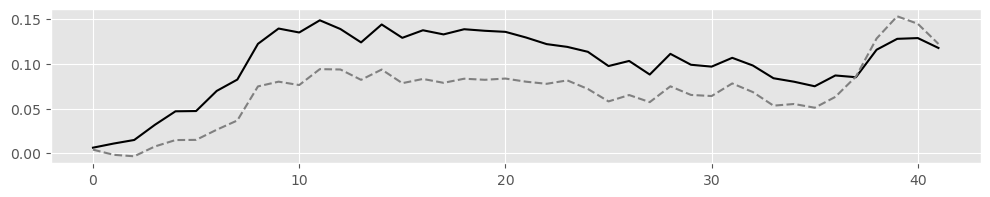


Episode 2/15, episilon=0.95

Episode 3/15, episilon=0.9025

Episode 4/15, episilon=0.8573749999999999

Episode 5/15, episilon=0.8145062499999999

Episode 6/15, episilon=0.7737809374999999


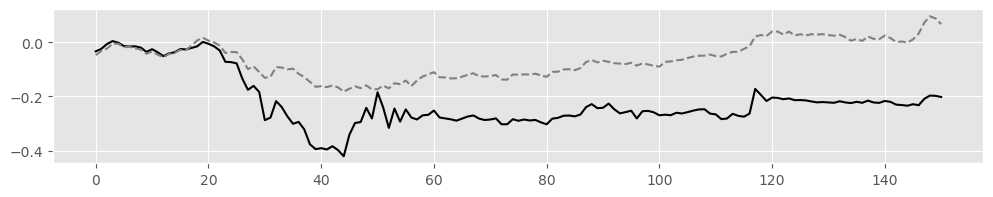


Episode 7/15, episilon=0.7350918906249998

Episode 8/15, episilon=0.6983372960937497

Episode 9/15, episilon=0.6634204312890623

Episode 10/15, episilon=0.6302494097246091

Episode 11/15, episilon=0.5987369392383786


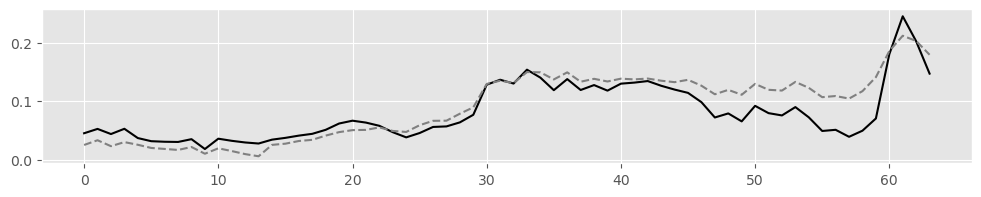


Episode 12/15, episilon=0.5688000922764596

Episode 13/15, episilon=0.5403600876626365

Episode 14/15, episilon=0.5133420832795047

Episode 15/15, episilon=0.48767497911552943


In [119]:
env = PortfolioEnv(input_file='data/df_price_0.csv', 
                   observe_window = 90, 
                   rebalance_window = 30)

q_estimator, stats = q_learning(env, 
                                inv_min_w=10,
                                n_episodes=15,
                                alpha=0.1,
                                epsilon=1.0,
                                epsilon_min=0.01,
                                epsilon_decay_rate=0.95,
                                gamma=0.95,
                                replay_batch_size=10)


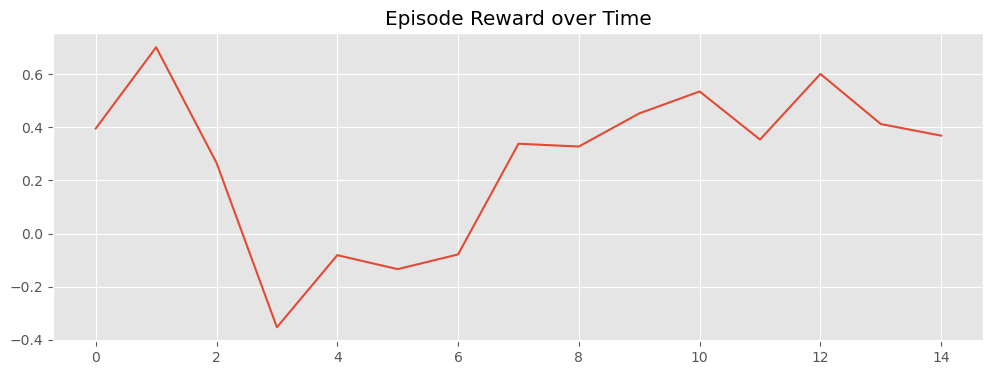

In [120]:
# check if Q converged
plt.figure(figsize = (12, 4))
plt.plot(stats.episode_rewards)
plt.title("Episode Reward over Time")

plt.show()

In [12]:
# save model
# with open('model/q_estimator_train_v2_1_sha.pkl', 'wb') as f:
#     pkl.dump(q_estimator, f)

# load model
with open('model/q_estimator_train_v2_1_sha.pkl', 'rb') as f:
    q_estimator = pkl.load(f)

### Model Testing - data subset 0

/var/folders/ln/80gw881d7y96pvkclfwfx0lh0000gn/T/ipykernel_20681/3033822524.py:37: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.returns = data.pct_change().dropna().values


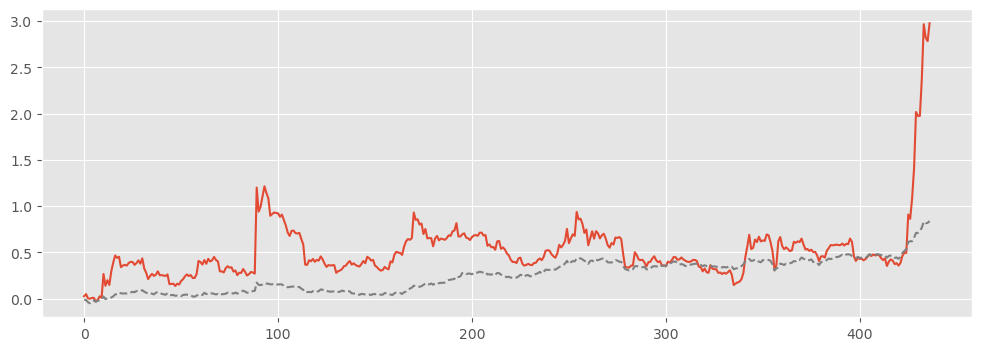

In [13]:
returns_recorder_bm = []
returns_recorder = []
actions_recorder = []

# Reset the environment
env = PortfolioEnv(input_file="data/df_price_test.csv", 
                    observe_window = 90, 
                    rebalance_window = 30)
state = env.reset()
inv_min_w=10
# action space
A = action_space(inv_min_w, env.n_asset)   
# The policy we're following
policy = epsilon_greedy_policy(env.n_asset, A)
# Benchmark policy (equal weights)
policy_bm = uni_policy(env.n_asset)

for t in itertools.count():
    
    # Take a step
    action = policy(state, q_estimator, epsilon=0)  # set epsilon=0 to use the optimal policy
    action_bm = policy_bm(state)
    reward, done, next_state = env.step(action)
    # if done:
    #     break   
    reward_bm = env.check_reward(action_bm) 
    
    # Update recorders and statistics
    returns_recorder_bm.extend(reward_bm[0]) # daily returns of the benchmark portfolio
    # actions_recorder.extend(action)
    actions_recorder.append(action)
    returns_recorder.extend(reward[0]) # daily returns of the portfolio
    if done:
        break   
    state = next_state

plt.figure(figsize = (12, 4))
plt.plot(np.cumprod(np.array(returns_recorder)+1)-1, ls = '-')
plt.plot(np.cumprod(np.array(returns_recorder_bm)+1)-1, color = 'grey', ls = '--')
plt.show()

/var/folders/ln/80gw881d7y96pvkclfwfx0lh0000gn/T/ipykernel_5738/3591451486.py:37: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.returns = data.pct_change().dropna().values


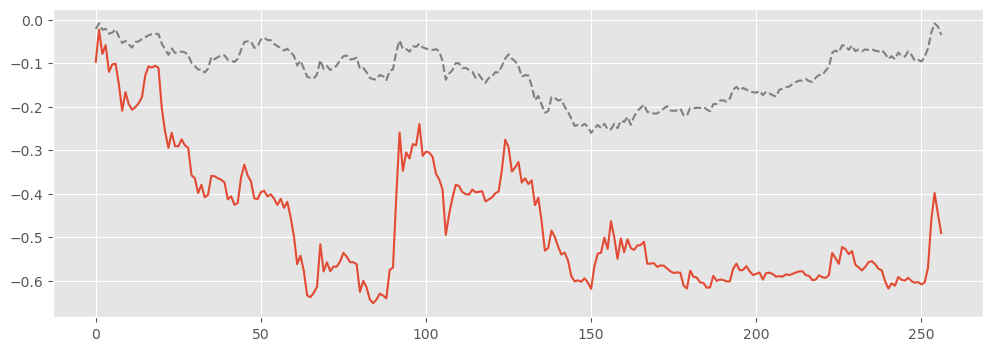

In [123]:
returns_recorder_bm = []
returns_recorder = []
actions_recorder = []

# Reset the environment
env = PortfolioEnv(input_file="data/df_price_0.csv", 
                    observe_window = 90, 
                    rebalance_window = 30)
state = env.reset()
inv_min_w=10
# action space
A = action_space(inv_min_w, env.n_asset)   
# The policy we're following
policy = epsilon_greedy_policy(env.n_asset, A)
# Benchmark policy (equal weights)
policy_bm = uni_policy(env.n_asset)

for t in itertools.count():
    
    # Take a step
    action = policy(state, q_estimator, epsilon=0)  # set epsilon=0 to use the optimal policy
    action_bm = policy_bm(state)
    reward, done, next_state = env.step(action)
    # if done:
    #     break   
    reward_bm = env.check_reward(action_bm) 
    
    # Update recorders and statistics
    returns_recorder_bm.extend(reward_bm[0]) # daily returns of the benchmark portfolio
    # actions_recorder.extend(action)
    actions_recorder.append(action)
    returns_recorder.extend(reward[0]) # daily returns of the portfolio
    if done:
        break   
    state = next_state

plt.figure(figsize = (12, 4))
plt.plot(np.cumprod(np.array(returns_recorder)+1)-1, ls = '-')
plt.plot(np.cumprod(np.array(returns_recorder_bm)+1)-1, color = 'grey', ls = '--')
plt.show()

In [14]:
# len(actions_recorder)
actions_recorder
# actions_recorder_norm = []
# for i in actions_recorder:
#     actions_recorder_norm.append(env.normalize(i))

# actions_recorder_norm
# test = [1,1,1,1,1,1,0,-1,-1,-1,-1,-1,-1]
# test_norm = env.normalize(test)
# np.sum(test_norm)
# test_norm

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10]]